# Profiling & Analysis

## Comprehensive Performance Analysis of VITS TTS Model

This notebook focuses on:
- **Performance Profiling**: Measuring Real-Time Factor (RTF) for different components
- **Bottleneck Identification**: Using PyTorch profiler to identify performance bottlenecks
- **Memory Analysis**: Understanding memory usage patterns
- **Component Analysis**: Detailed profiling of Text Encoder, Duration Predictor, HiFi-GAN Vocoder, and Flow-based Prior

### Key Metrics:
- **RTF (Real-Time Factor)**: Ratio of synthesis time to audio duration (lower is better)
- **Component Timing**: Individual timing for each VITS component
- **Memory Usage**: Peak and sustained memory consumption
- **GPU Utilization**: Efficiency of GPU resource usage

In [1]:
# Import necessary libraries for profiling and analysis
import time
import os
import gc
import sys
import contextlib
from io import StringIO
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import torch
import torch.profiler
from torch.profiler import profile, record_function, ProfilerActivity
import psutil
import GPUtil
from TTS.api import TTS
from TTS.tts.models.vits import Vits
from TTS.tts.configs.vits_config import VitsConfig
import warnings
warnings.filterwarnings('ignore')

# Set up device and random seed for reproducible results
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Create output directory for this notebook
output_dir = Path('../results/profiling_analysis')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"\n✓ Output directory created: {output_dir}")
print(f"  All results will be saved to: {output_dir.absolute()}")


Device: cuda
PyTorch version: 2.8.0+cu128
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
GPU Memory: 4.3 GB

✓ Output directory created: ../results/profiling_analysis
  All results will be saved to: /mnt/d/Academic/AML/In21-S7-CS4681-AML-Research-Projects/projects/210086E-NLP_Text-to-Speech/experiments/../results/profiling_analysis


In [2]:
@contextlib.contextmanager
def suppress_stdout_stderr():
    """Context manager to suppress stdout and stderr"""
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    try:
        sys.stdout = StringIO()
        sys.stderr = StringIO()
        yield
    finally:
        sys.stdout = old_stdout
        sys.stderr = old_stderr

In [3]:
# Load VITS model for profiling
model_name = "tts_models/en/vctk/vits"
tts = TTS(model_name, gpu=True).to(device)

 > tts_models/en/vctk/vits is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.


In [4]:
# Test data for consistent profiling
test_texts = [
    # ~10–30 chars (short)
    "Hello there!",
    "Testing audio.",
    "Good morning!",
    "Quick check.",
    "Simple sentence.",
    "Nice to meet you.",
    "I like this test.",
    "Short text only.",
    "Speech synthesis!",
    "Model warm-up run.",
    
    # ~30–60 chars
    "The quick brown fox jumps over the lazy dog.",
    "Time to test the TTS pipeline today.",
    "Machine learning improves voice quality.",
    "Profiling model speed is essential.",
    "This one checks mid-length processing.",
    "Audio clarity depends on many factors.",
    "Let's benchmark synthesis performance.",
    "Real-time output is the goal here.",
    "Memory usage should be monitored.",
    "Ensure consistent inference quality.",
    
    # ~60–90 chars
    "Text-to-speech models generate human-like voices from written text.",
    "Performance metrics like RTF help evaluate model efficiency.",
    "Profiling helps locate time-consuming functions in the TTS model.",
    "Accuracy and fluency are key indicators of speech quality.",
    "Model latency directly affects user experience in voice systems.",
    "Neural vocoders reconstruct audio from mel-spectrograms efficiently.",
    "Speech generation involves multiple neural network components.",
    "Duration predictors estimate timing of phonemes in speech.",
    "Better attention alignment improves pronunciation accuracy.",
    "Consistent voice tone requires stable conditioning inputs.",
    
    # ~90–130 chars
    "The VITS model integrates variational inference and adversarial learning for natural speech generation.",
    "High-quality synthesis demands precise control over rhythm, tone, and duration parameters.",
    "Batch inference helps utilize hardware efficiently while maintaining consistent throughput.",
    "Latency measurements reveal how long a model takes to generate each second of speech.",
    "Post-processing often includes normalization and noise reduction for clearer output.",
    "Model optimization involves pruning, quantization, and mixed-precision inference.",
    "Dataset quality directly impacts the clarity and expressiveness of generated voices.",
    "Fine-tuning improves speaker-specific characteristics in multi-speaker models.",
    "Adversarial loss encourages the generator to produce more realistic speech.",
    "The decoder reconstructs waveform samples from latent acoustic representations.",
    
    # ~130–170 chars
    "Real-time factor (RTF) is a standard benchmark indicating how fast a model can synthesize speech relative to audio duration.",
    "Mel-spectrograms represent frequency energy across time and are essential for speech reconstruction.",
    "Neural TTS architectures often combine encoders, duration predictors, and vocoders into a single pipeline.",
    "Inference efficiency can vary based on batch size, sequence length, and computational resources.",
    "Multi-speaker datasets enable the model to generalize across various voice tones and accents.",
    "Training data diversity improves prosody and prevents monotonic or robotic speech patterns.",
    "Quantized models can run efficiently on CPUs without significantly degrading speech quality.",
    "Profiling reveals which network layers contribute most to runtime and memory consumption.",
    "Data preprocessing includes phoneme conversion, normalization, and tokenization of input text.",
    "Speech models benefit from regularization to prevent overfitting and improve generalization.",
    
    # ~170–210 chars
    "End-to-end text-to-speech systems eliminate the need for separate phoneme alignment by learning duration and acoustic mappings jointly within the neural network architecture.",
    "Attention mechanisms align textual and acoustic features, enabling smooth temporal synchronization between words and their corresponding sounds.",
    "Recent advances in neural vocoders like HiFi-GAN and WaveGlow have significantly improved the fidelity and realism of generated speech audio.",
    "Mixed-precision training reduces memory footprint and speeds up computation while maintaining numerical stability in large-scale models.",
    "Cross-lingual transfer learning allows a speech model trained on one language to adapt quickly to another with limited new data.",
    "Perceptual evaluation of speech quality (PESQ) provides an objective measure of how human listeners perceive synthesized audio.",
    "Model distillation can compress large speech models into smaller, faster versions while preserving intelligibility.",
    "Adaptive tokenization strategies enable better handling of rare words, numbers, and code-mixed language inputs.",
    "Hardware-aware optimization tailors kernel execution for CPUs, GPUs, or specialized AI accelerators.",
    "Dynamic batching helps improve throughput by combining multiple requests of varying lengths efficiently.",
    
    # ~210–250 chars
    "Advanced text-to-speech systems such as VITS and Tacotron 2 integrate multiple learning objectives to balance linguistic, acoustic, and adversarial components for achieving highly expressive and natural-sounding speech generation.",
    "Profiling large neural networks requires capturing detailed traces of CPU and GPU utilization, kernel-level execution, memory transfers, and caching behavior to identify potential performance bottlenecks accurately.",
    "Evaluating speech synthesis involves both objective metrics like RTF and subjective assessments such as Mean Opinion Score (MOS), providing a holistic view of performance and perceptual quality.",
    "Modern inference frameworks leverage optimized graph compilers and kernel fusion to reduce latency, eliminate redundant operations, and enhance throughput across heterogeneous hardware backends.",
    "Hybrid systems combine neural vocoders with rule-based prosody control to achieve fine-grained expressive control without sacrificing efficiency in real-time voice generation."
]

test_texts_shorten = [
    "Hi there!",
    "The quick brown fox jumps over the lazy dog.",
    "This is a longer sentence to test the performance of the text-to-speech synthesis system.",
    "Very long text with multiple sentences. This allows us to measure performance across different input lengths. The synthesis quality and speed may vary based on text complexity.",
    "The variational autoencoder framework enables probabilistic modeling of speech synthesis."
]

speaker_id = "p225"
sample_rate = 22050

## 2.1 Performance Profiling - RTF Measurements

Real-Time Factor (RTF) is a critical metric for TTS systems:
- **RTF < 1.0**: Faster than real-time (good for production)
- **RTF = 1.0**: Real-time synthesis 
- **RTF > 1.0**: Slower than real-time (may cause stuttering in applications)

We'll measure RTF for:
1. Overall VITS model
2. Individual components (when possible)
3. Different text lengths
4. Cold vs warm inference

### RTF Measurement Function

In [5]:
def measure_rtf(model, text_input, speaker=None, num_runs=3, warmup=True):
    """
    Measure Real-Time Factor (RTF) for TTS synthesis
    
    Args:
        model: TTS model instance
        text_input: Input text string
        speaker: Speaker ID (if applicable)
        num_runs: Number of runs for averaging
        warmup: Whether to perform warmup run
    
    Returns:
        dict: Contains RTF, inference_time, audio_duration, and statistics
    """
    results = {
        'text': text_input,
        'text_length': len(text_input),
        'speaker': speaker,
        'inference_times': [],
        'audio_durations': [],
        'rtfs': []
    }
    
    # Warmup run (doesn't count towards statistics)
    if warmup:
        try:
            with suppress_stdout_stderr():
                if speaker:
                    _ = model.tts(text_input, speaker=speaker)
                else:
                    _ = model.tts(text_input)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
        except Exception as e:
            print(f"Warmup failed: {e}")
    
    # Main measurement runs
    for run in range(num_runs):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        start = time.perf_counter()
        try:
            with torch.no_grad():
                with suppress_stdout_stderr():
                    if speaker:
                        audio = model.tts(text_input, speaker=speaker)
                    else:
                        audio = model.tts(text_input)
        except Exception as e:
            print(f"TTS failed on run {run}: {e}")
            continue
            
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        inference_time = time.perf_counter() - start
        
        # Calculate audio duration
        if isinstance(audio, torch.Tensor):
            audio_samples = len(audio)
        else:
            audio_samples = len(audio)
        
        audio_duration = audio_samples / sample_rate
        rtf = inference_time / audio_duration
        
        results['inference_times'].append(inference_time)
        results['audio_durations'].append(audio_duration)
        results['rtfs'].append(rtf)
    
    # Calculate statistics
    if results['rtfs']:
        results['mean_rtf'] = np.mean(results['rtfs'])
        results['std_rtf'] = np.std(results['rtfs'])
        results['min_rtf'] = np.min(results['rtfs'])
        results['max_rtf'] = np.max(results['rtfs'])
        results['mean_inference_time'] = np.mean(results['inference_times'])
        results['mean_audio_duration'] = np.mean(results['audio_durations'])
    
    return results

In [6]:
# Function to run comprehensive RTF analysis
def comprehensive_rtf_analysis(model, texts, speaker=None):
    all_results = []
    
    print("Running comprehensive RTF analysis...")
    print("=" * 50, "\n")
    
    for i, text in enumerate(texts):
        print(f"Text {i+1}: '{text[:50]}{'...' if len(text) > 50 else ''}'")
        result = measure_rtf(model, text, speaker=speaker)
        all_results.append(result)
    
    return all_results

In [7]:
# Run initial RTF analysis
rtf_results = comprehensive_rtf_analysis(tts, test_texts, speaker=speaker_id)

Running comprehensive RTF analysis...

Text 1: 'Hello there!'
Text 2: 'Testing audio.'
Text 3: 'Good morning!'
Text 4: 'Quick check.'
Text 5: 'Simple sentence.'
Text 6: 'Nice to meet you.'
Text 7: 'I like this test.'
Text 8: 'Short text only.'
Text 9: 'Speech synthesis!'
Text 10: 'Model warm-up run.'
Text 11: 'The quick brown fox jumps over the lazy dog.'
Text 12: 'Time to test the TTS pipeline today.'
Text 13: 'Machine learning improves voice quality.'
Text 14: 'Profiling model speed is essential.'
Text 15: 'This one checks mid-length processing.'
Text 16: 'Audio clarity depends on many factors.'
Text 17: 'Let's benchmark synthesis performance.'
Text 18: 'Real-time output is the goal here.'
Text 19: 'Memory usage should be monitored.'
Text 20: 'Ensure consistent inference quality.'
Text 21: 'Text-to-speech models generate human-like voices f...'
Text 22: 'Performance metrics like RTF help evaluate model e...'
Text 23: 'Profiling helps locate time-consuming functions in...'
Text 24: 'A

In [8]:
# Create results DataFrame for easier analysis
rtf_df = pd.DataFrame([
    {
        'text_length': r['text_length'],
        'mean_rtf': r.get('mean_rtf', np.nan),
        'std_rtf': r.get('std_rtf', np.nan),
        'inference_time': r.get('mean_inference_time', np.nan),
        'audio_duration': r.get('mean_audio_duration', np.nan),
        'text_preview': r['text'][:30] + '...' if len(r['text']) > 30 else r['text']
    }
    for r in rtf_results
])

rtf_df.head()

,text_length,mean_rtf,std_rtf,inference_time,audio_duration,text_preview
0,12,0.155260,0.054042,0.205308,1.320393,Hello there!
1,14,0.103490,0.021555,0.163977,1.587423,Testing audio.
2,13,0.095843,0.013050,0.138034,1.436493,Good morning!
3,12,0.102186,0.014297,0.153741,1.506153,Quick check.
4,16,0.067736,0.010536,0.131998,1.947332,Simple sentence.


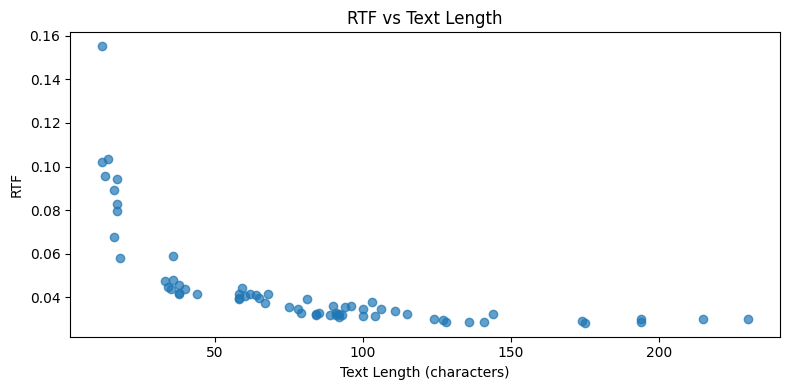

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
# Quick visualization
if len(rtf_df) > 1:
    plt.figure(figsize=(8, 4))
    
    plt.scatter(rtf_df['text_length'], rtf_df['mean_rtf'], alpha=0.7)
    plt.xlabel('Text Length (characters)')
    plt.ylabel('RTF')
    plt.title('RTF vs Text Length')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'rtf_vs_textlength_scatter_plot.png', dpi=300, bbox_inches='tight')
    plt.show()


## 2.2 Component-Specific Profiling

VITS consists of several key components:
1. **Text Encoder** (Transformer-based): Converts text to linguistic features
2. **Duration Predictor**: Predicts phoneme durations for alignment
3. **Flow-based Prior**: Generates latent representations
4. **HiFi-GAN Vocoder**: Converts mel-spectrograms to audio (often the bottleneck)

We'll profile each component individually to identify performance bottlenecks.

In [10]:
def profile_vits_components(model, text, components, speaker_id=None, num_runs=3):
    """
    Profile individual VITS components using forward hooks.
    
    Args:
        model: TTS model instance
        text: Input text to synthesize
        components: Dict of {name: module} to profile
        speaker_id: Optional speaker ID
        num_runs: Number of profiling runs
    
    Returns:
        Dict with timing stats for each component
    """
    # Storage for timing results
    component_times = {name: [] for name in components.keys()}
    component_times.update({"inference": [], "total": []})
    
    print(f"Profiling: '{text[:60]}{'...' if len(text) > 60 else ''}'")
    
    for run in range(num_runs):
        # Track component times for this run
        timings = {name: 0.0 for name in components.keys()}
        
        # Define hook functions
        def make_pre_hook(name):
            def hook(module, inputs):
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                timings[f"{name}_start"] = time.time()
            return hook
        
        def make_post_hook(name):
            def hook(module, inputs, output):
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                start = timings.get(f"{name}_start")
                if start:
                    timings[name] += time.time() - start
            return hook
        
        # Register hooks
        hooks = []
        for name, module in components.items():
            hooks.append(module.register_forward_pre_hook(make_pre_hook(name)))
            hooks.append(module.register_forward_hook(make_post_hook(name)))
        
        try:
            # Run inference
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            total_start = time.time()
            
            with torch.no_grad():
                inference_start = time.time()
                with record_function("vits_inference"):
                    with suppress_stdout_stderr():
                        if speaker_id is not None:
                            _ = model.tts(text, speaker=speaker_id)
                        else:
                            _ = model.tts(text)
                
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                
                inference_time = time.time() - inference_start
            
            total_time = time.time() - total_start
            
            # Store results
            component_times["inference"].append(inference_time)
            component_times["total"].append(total_time)
            
            for name in components.keys():
                component_times[name].append(timings[name])
        
        except Exception as e:
            print(f"Error in run {run + 1}: {e}")
        
        finally:
            # Clean up hooks
            for hook in hooks:
                hook.remove()
    
    # Calculate statistics
    stats = {}
    for component, times in component_times.items():
        if times:
            stats[component] = {
                "mean": np.mean(times),
                "std": np.std(times),
                "min": np.min(times),
                "max": np.max(times),
            }
    
    return stats


# Usage
vits_model = tts.synthesizer.tts_model

components = {
    "text_encoder": vits_model.text_encoder,
    "duration_predictor": vits_model.duration_predictor,
    "flow": vits_model.flow,
    "vocoder": vits_model.waveform_decoder,
}

# Profile components
component_results = []

for i, text in enumerate(test_texts_shorten, 1):
    print(f"\n--- Text {i} ---")
    
    stats = profile_vits_components(
        model=tts,
        text=text,
        components=components,
        speaker_id=speaker_id,
        num_runs=3
    )
    
    stats["text"] = text
    stats["text_length"] = len(text)
    component_results.append(stats)
    
    # Print results
    print("\nTiming Results:")
    for comp_name, comp_stats in stats.items():
        if isinstance(comp_stats, dict) and "mean" in comp_stats:
            print(f"  {comp_name:20s}: {comp_stats['mean']:.4f}s ± {comp_stats['std']:.4f}s")

print("\n✓ Component profiling completed!")


--- Text 1 ---
Profiling: 'Hi there!'

Timing Results:
  text_encoder        : 0.0181s ± 0.0050s
  duration_predictor  : 0.0263s ± 0.0095s
  flow                : 0.0147s ± 0.0027s
  vocoder             : 0.0436s ± 0.0156s
  inference           : 0.1228s ± 0.0299s
  total               : 0.1229s ± 0.0299s

--- Text 2 ---
Profiling: 'The quick brown fox jumps over the lazy dog.'

Timing Results:
  text_encoder        : 0.0126s ± 0.0001s
  duration_predictor  : 0.0177s ± 0.0000s
  flow                : 0.0107s ± 0.0001s
  vocoder             : 0.0611s ± 0.0018s
  inference           : 0.1251s ± 0.0018s
  total               : 0.1251s ± 0.0018s

--- Text 3 ---
Profiling: 'This is a longer sentence to test the performance of the tex...'

Timing Results:
  text_encoder        : 0.0129s ± 0.0005s
  duration_predictor  : 0.0177s ± 0.0001s
  flow                : 0.0164s ± 0.0001s
  vocoder             : 0.1039s ± 0.0020s
  inference           : 0.1762s ± 0.0028s
  total               : 0.176

In [11]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Prepare data for visualization
viz_data = []
for result in component_results:
    text_id = f"Text {len(viz_data) + 1}\n({result['text_length']} chars)"
    for comp_name, comp_stats in result.items():
        if isinstance(comp_stats, dict) and "mean" in comp_stats:
            viz_data.append({
                'Text': text_id,
                'Component': comp_name,
                'Mean Time (s)': comp_stats['mean'],
                'Std Dev': comp_stats['std'],
                'Text Length': result['text_length']
            })

df = pd.DataFrame(viz_data)
component_order = ['text_encoder', 'duration_predictor', 'flow', 'vocoder']

print("✓ Data prepared for visualization")
print(f"Total records: {len(df)}")
df.head(10)

✓ Data prepared for visualization
Total records: 30


,Text,Component,Mean Time (s),Std Dev,Text Length
0,Text 1\n(9 chars),text_encoder,0.018066,0.004995,9
1,Text 1\n(9 chars),duration_predictor,0.026265,0.009482,9
2,Text 1\n(9 chars),flow,0.014679,0.002743,9
3,Text 1\n(9 chars),vocoder,0.043554,0.015569,9
4,Text 1\n(9 chars),inference,0.122846,0.029908,9
5,Text 1\n(9 chars),total,0.122864,0.029909,9
6,Text 7\n(44 chars),text_encoder,0.012607,0.000081,44
7,Text 7\n(44 chars),duration_predictor,0.017738,0.000047,44
8,Text 7\n(44 chars),flow,0.010710,0.000066,44
9,Text 7\n(44 chars),vocoder,0.061104,0.001792,44


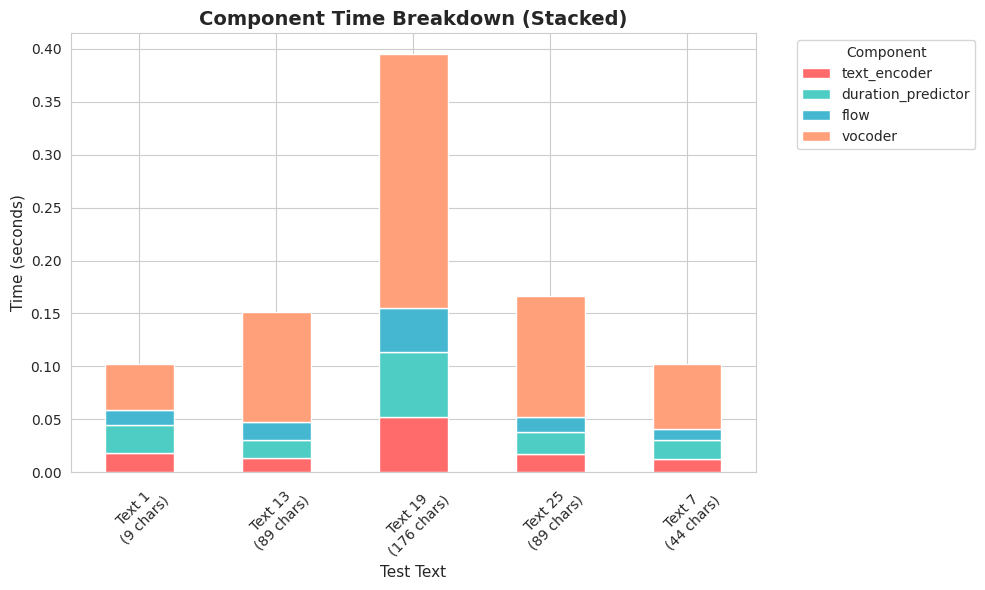

✓ Saved: 1_stacked_bar.png


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot 1 - Stacked Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

pivot_data = df[df['Component'].isin(component_order)].pivot(
    index='Text', columns='Component', values='Mean Time (s)'
)[component_order]

pivot_data.plot(kind='bar', stacked=True, ax=ax, 
                color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
ax.set_title('Component Time Breakdown (Stacked)', fontsize=14, fontweight='bold')
ax.set_xlabel('Test Text', fontsize=11)
ax.set_ylabel('Time (seconds)', fontsize=11)
ax.legend(title='Component', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / '1_stacked_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 1_stacked_bar.png")


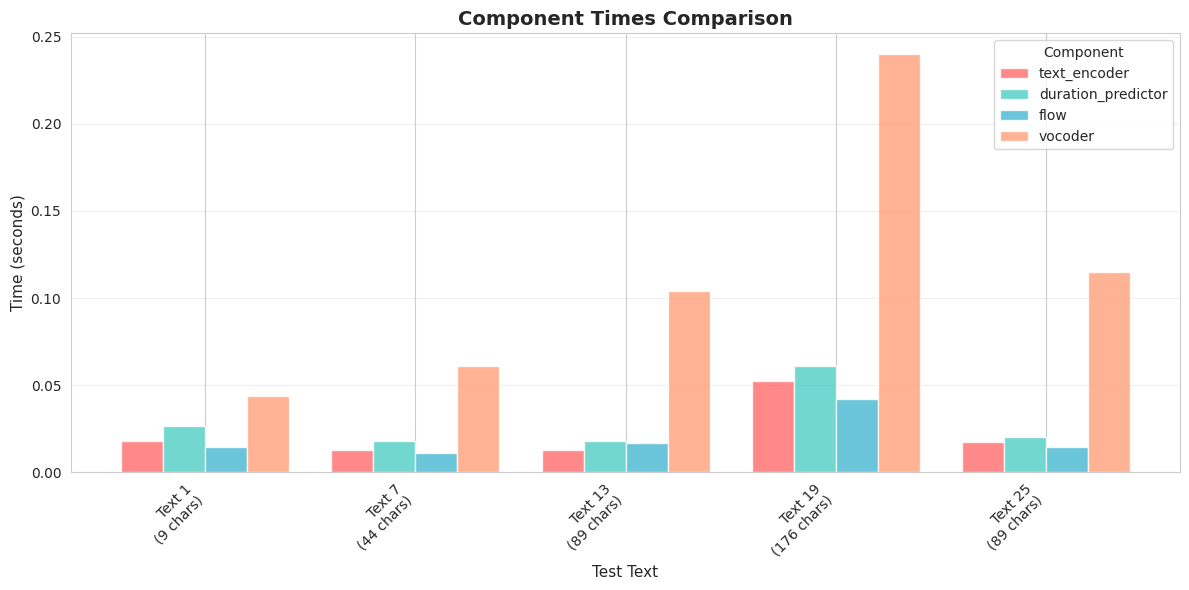

✓ Saved: 2_grouped_bar.png


In [13]:
# Plot 2 - Grouped Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))

component_df = df[df['Component'].isin(component_order)]
x = np.arange(len(component_df['Text'].unique()))
width = 0.2
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for i, comp in enumerate(component_order):
    comp_data = component_df[component_df['Component'] == comp]
    positions = x + (i - 1.5) * width
    ax.bar(positions, comp_data['Mean Time (s)'], width, 
           label=comp, alpha=0.8, color=colors[i])

ax.set_title('Component Times Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Test Text', fontsize=11)
ax.set_ylabel('Time (seconds)', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(component_df['Text'].unique(), rotation=45, ha='right')
ax.legend(title='Component', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / '2_grouped_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 2_grouped_bar.png")


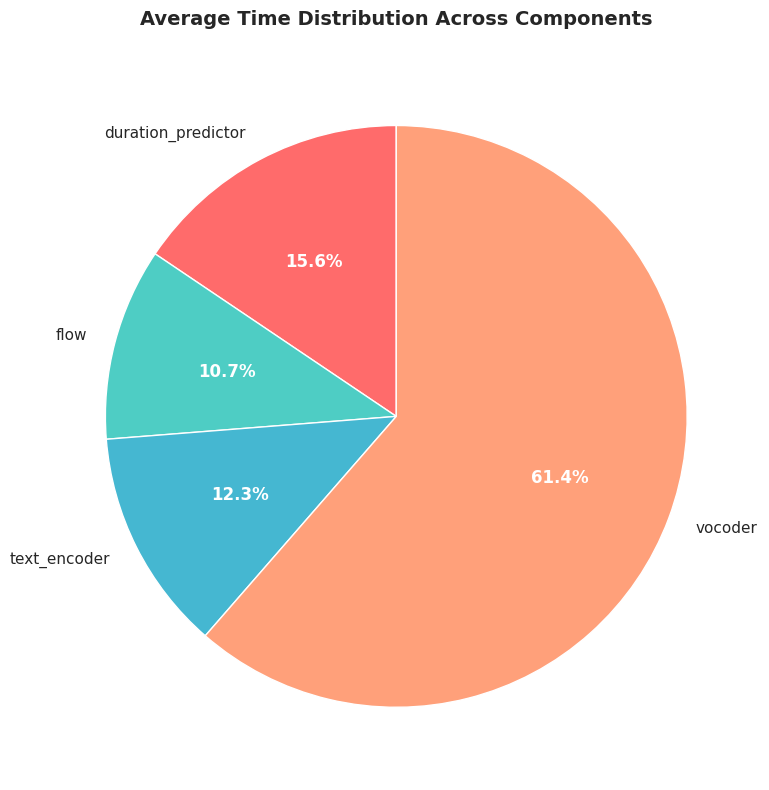

✓ Saved: 3_pie_chart.png


In [14]:
# Plot 3 - Pie Chart
fig, ax = plt.subplots(figsize=(10, 8))

avg_times = df[df['Component'].isin(component_order)].groupby('Component')['Mean Time (s)'].mean()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

wedges, texts, autotexts = ax.pie(avg_times, labels=avg_times.index, autopct='%1.1f%%',
                                    colors=colors, startangle=90, textprops={'fontsize': 11})
ax.set_title('Average Time Distribution Across Components', fontsize=14, fontweight='bold', pad=20)

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.savefig(output_dir / '3_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 3_pie_chart.png")


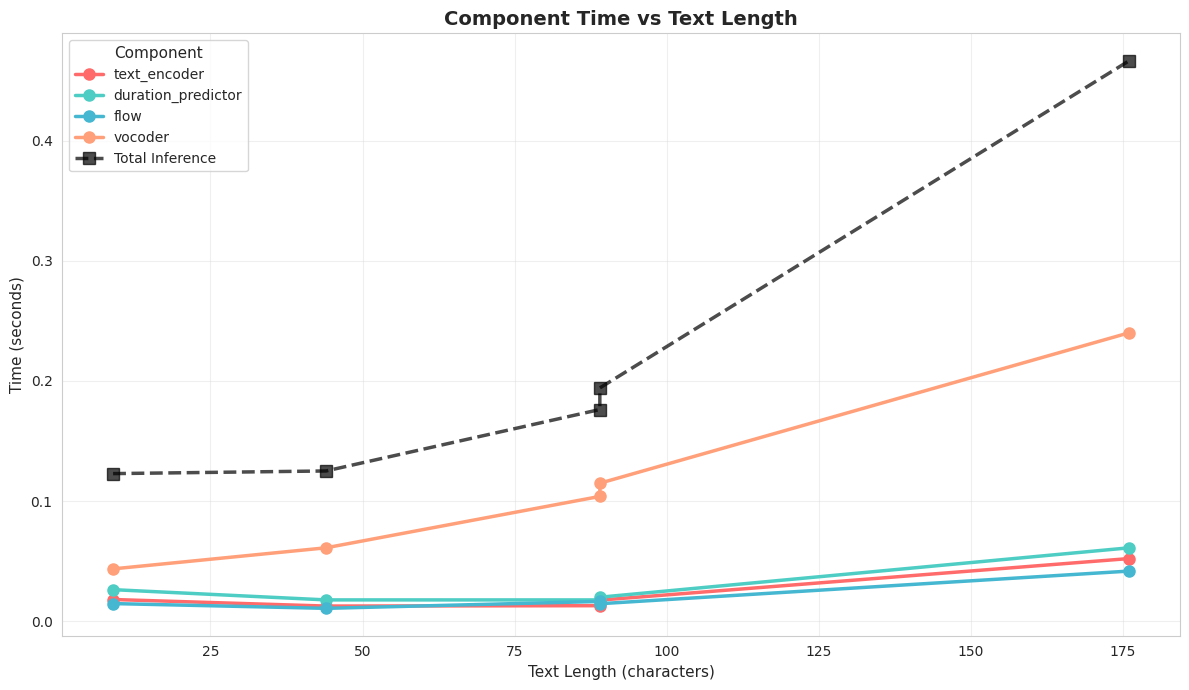

✓ Saved: 4_line_scaling.png


In [15]:
# Plot 4 - Line Plot (Scaling Analysis)
fig, ax = plt.subplots(figsize=(12, 7))

colors_line = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for i, comp in enumerate(component_order):
    comp_data = df[df['Component'] == comp].sort_values('Text Length')
    ax.plot(comp_data['Text Length'], comp_data['Mean Time (s)'], 
            marker='o', label=comp, linewidth=2.5, markersize=8, color=colors_line[i])

# Also plot total inference time
total_data = df[df['Component'] == 'inference'].sort_values('Text Length')
ax.plot(total_data['Text Length'], total_data['Mean Time (s)'], 
        marker='s', label='Total Inference', linewidth=2.5, linestyle='--', 
        color='black', markersize=8, alpha=0.7)

ax.set_title('Component Time vs Text Length', fontsize=14, fontweight='bold')
ax.set_xlabel('Text Length (characters)', fontsize=11)
ax.set_ylabel('Time (seconds)', fontsize=11)
ax.legend(title='Component', fontsize=10, title_fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / '4_line_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 4_line_scaling.png")


In [16]:
# Summary Statistics
print("=" * 70)
print("COMPONENT PROFILING SUMMARY".center(70))
print("=" * 70)

summary = df[df['Component'].isin(component_order)].groupby('Component').agg({
    'Mean Time (s)': ['mean', 'std', 'min', 'max']
}).round(4)

print("\nAverage timing across all texts:")
print(summary)
print()

# Find bottleneck
avg_by_component = df[df['Component'].isin(component_order)].groupby('Component')['Mean Time (s)'].mean()
bottleneck = avg_by_component.idxmax()
bottleneck_pct = (avg_by_component[bottleneck] / avg_by_component.sum()) * 100

print(f"\n{'🔍 Performance Bottleneck Analysis':^70}")
print("-" * 70)
print(f"  Bottleneck Component: {bottleneck}")
print(f"  Average Time: {avg_by_component[bottleneck]:.4f}s")
print(f"  Percentage of Total: {bottleneck_pct:.1f}%")
print()

# Show all component percentages
print(f"\n{'Component Time Breakdown':^70}")
print("-" * 70)
for comp in component_order:
    pct = (avg_by_component[comp] / avg_by_component.sum()) * 100
    bar = '█' * int(pct / 2)
    print(f"  {comp:20s}: {avg_by_component[comp]:.4f}s ({pct:5.1f}%) {bar}")

print("\n" + "=" * 70)
print(f"✓ All visualizations saved in {output_dir.absolute()}")
print("=" * 70)


                     COMPONENT PROFILING SUMMARY                      

Average timing across all texts:
                   Mean Time (s)                        
                            mean     std     min     max
Component                                               
duration_predictor        0.0286  0.0185  0.0177  0.0611
flow                      0.0196  0.0125  0.0107  0.0417
text_encoder              0.0227  0.0167  0.0126  0.0521
vocoder                   0.1127  0.0771  0.0436  0.2401


                  🔍 Performance Bottleneck Analysis                   
----------------------------------------------------------------------
  Bottleneck Component: vocoder
  Average Time: 0.1127s
  Percentage of Total: 61.4%


                       Component Time Breakdown                       
----------------------------------------------------------------------
  text_encoder        : 0.0227s ( 12.3%) ██████
  duration_predictor  : 0.0286s ( 15.6%) ███████
  flow                : 0.

## 2.3 PyTorch Profiler Analysis

The PyTorch profiler provides detailed insights into:
- **CPU and GPU utilization**
- **Memory allocation patterns**
- **Kernel execution times**
- **Data transfer bottlenecks**
- **Operator-level performance**

This analysis helps identify the most time-consuming operations in VITS.

In [17]:
import os
import time
import torch
from torch.profiler import profile, record_function, ProfilerActivity
from IPython.display import display, Markdown

def run_pytorch_profiler(model, text, speaker_id=None, profile_gpu=True):
    """
    Run PyTorch profiler to identify performance bottlenecks.
    
    Args:
        model: VITS model instance
        text: Input text for synthesis
        speaker_id: Optional speaker ID for multi-speaker models
        profile_gpu: Whether to profile GPU operations
        
    Returns:
        PyTorch profiler object with detailed metrics
    """
    activities = [ProfilerActivity.CPU]
    if profile_gpu and torch.cuda.is_available():
        activities.append(ProfilerActivity.CUDA)
    
    # Warmup run
    with torch.no_grad():
        if speaker_id:
            _ = model.tts(text, speaker=speaker_id)
        else:
            _ = model.tts(text)
    
    # Profile execution
    with profile(
        activities=activities,
        record_shapes=True,
        profile_memory=True,
        with_stack=True,
        experimental_config=torch._C._profiler._ExperimentalConfig(verbose=True)
    ) as prof:
        with record_function("vits_inference"):
            with torch.no_grad():
                if speaker_id:
                    _ = model.tts(text, speaker=speaker_id)
                else:
                    _ = model.tts(text)
    
    return prof


def display_profiler_results(prof, export_trace=True, trace_dir="../results/profiling_analysis/traces_vits"):
    """
    Display profiler results in formatted tables.
    
    Args:
        prof: PyTorch profiler object
        export_trace: Whether to export Chrome trace file
        trace_dir: Directory for trace export
    """
    display(Markdown("## PyTorch Profiler Results"))
    
    # CPU operations
    display(Markdown("#### Top CPU Operations"))
    cpu_table = prof.key_averages().table(
        sort_by="cpu_time_total", 
        row_limit=15
    )
    print(cpu_table)
    
    # GPU operations (if available)
    if torch.cuda.is_available():
        display(Markdown("#### Top GPU Operations"))
        gpu_table = prof.key_averages().table(
            sort_by="cuda_time_total", 
            row_limit=15
        )
        print(gpu_table)
    
    # Memory usage
    display(Markdown("#### Memory Usage Summary"))
    memory_table = prof.key_averages().table(
        sort_by="self_cuda_memory_usage", 
        row_limit=10
    )
    print(memory_table)
    
    # Export trace for visualization
    if export_trace:
        os.makedirs(trace_dir, exist_ok=True)
        trace_file = os.path.join(
            trace_dir, 
            f"vits_trace_{int(time.time()*1000000)}.json"
        )
        try:
            prof.export_chrome_trace(trace_file)
            display(Markdown(f"### Trace Exported\n**File:** `{trace_file}`\n\n"
                           f"Open in Chrome: `chrome://tracing`"))
            return trace_file
        except Exception as e:
            display(Markdown(f"**Warning:** Failed to export trace: {e}"))
            return None


# Run profiling analysis
test_text = test_texts[11]  # Use medium-length text
prof = run_pytorch_profiler(tts, test_text, speaker_id)

# Display results
trace_file = display_profiler_results(prof)

# Store results
profiling_results = {
    'profiler': prof,
    'test_text': test_text,
    'trace_file': trace_file
}

 > Text splitted to sentences.
['Time to test the TTS pipeline today.']
 > Processing time: 0.38065004348754883
 > Real-time factor: 0.12854284273003633
 > Text splitted to sentences.
['Time to test the TTS pipeline today.']
 > Processing time: 0.32323408126831055
 > Real-time factor: 0.10583439492703504


## PyTorch Profiler Results

#### Top CPU Operations

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         vits_inference        15.57%      50.514ms       100.00%     324.503ms     324.503ms       0.000us         0.00%     260.859ms     260.859ms           0 B    -224.77 KB           0 B      -1.22 G

#### Top GPU Operations

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         vits_inference         0.00%       0.000us         0.00%       0.000us       0.000us     294.577ms       112.93%     294.577ms     294.577ms           0 B           0 B           0 B           0 

#### Memory Usage Summary

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       aten::leaky_relu         0.27%     872.335us         0.68%       2.222ms      28.851us      16.810ms         6.44%      16.810ms     218.309us           0 B           0 B     435.19 MB     435.19 M

### Trace Exported
**File:** `../results/traces_vits/vits_trace_1760954713406049.json`

Open in Chrome: `chrome://tracing`

## 2.4 Memory Profiling & Analysis

Memory efficiency is crucial for TTS deployment:
- **Peak Memory Usage**: Maximum memory consumption during inference
- **Memory Allocation Patterns**: How memory is allocated over time
- **Component Memory Usage**: Memory usage by different VITS components
- **Memory Leaks**: Detection of potential memory leaks in long sequences

In [18]:
# Memory profiling functions
def get_memory_usage():
    """Get current memory usage statistics"""
    memory_stats = {}
    
    # System memory
    process = psutil.Process()
    memory_stats['system_ram_mb'] = process.memory_info().rss / 1024 / 1024
    memory_stats['system_ram_percent'] = process.memory_percent()
    
    # GPU memory (if available)
    if torch.cuda.is_available():
        memory_stats['gpu_allocated_mb'] = torch.cuda.memory_allocated() / 1024 / 1024
        memory_stats['gpu_cached_mb'] = torch.cuda.memory_reserved() / 1024 / 1024
        memory_stats['gpu_max_allocated_mb'] = torch.cuda.max_memory_allocated() / 1024 / 1024
    
    return memory_stats

In [19]:
def profile_memory_usage(model, texts, speaker_id=None):
    """Profile memory usage across different text lengths"""
    memory_results = []
    
    print("Profiling memory usage...")
    print("=" * 50, "\n")
    
    for i, text in enumerate(texts):
        print(f"Text {i+1} (Length: {len(text)} chars)")
        
        # Clear cache and collect garbage
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
        gc.collect()
        
        # Baseline memory
        baseline_memory = get_memory_usage()
        
        # Run inference and track memory
        with torch.no_grad():
            with suppress_stdout_stderr():
                if speaker_id:
                    audio = model.tts(text, speaker=speaker_id)
                else:
                    audio = model.tts(text)
        
        # Peak memory during inference
        peak_memory = get_memory_usage()
        
        # Memory after inference
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        post_memory = get_memory_usage()
        
        result = {
            'text_length': len(text),
            'text_preview': text[:30] + '...' if len(text) > 30 else text,
            'baseline_memory': baseline_memory,
            'peak_memory': peak_memory,
            'post_memory': post_memory
        }
        
        memory_results.append(result)
        
    return memory_results

In [20]:
# Run memory profiling
memory_results = profile_memory_usage(tts, test_texts, speaker_id)

Profiling memory usage...

Text 1 (Length: 12 chars)
Text 2 (Length: 14 chars)
Text 3 (Length: 13 chars)
Text 4 (Length: 12 chars)
Text 5 (Length: 16 chars)
Text 6 (Length: 17 chars)
Text 7 (Length: 17 chars)
Text 8 (Length: 16 chars)
Text 9 (Length: 17 chars)
Text 10 (Length: 18 chars)
Text 11 (Length: 44 chars)
Text 12 (Length: 36 chars)
Text 13 (Length: 40 chars)
Text 14 (Length: 35 chars)
Text 15 (Length: 38 chars)
Text 16 (Length: 38 chars)
Text 17 (Length: 38 chars)
Text 18 (Length: 34 chars)
Text 19 (Length: 33 chars)
Text 20 (Length: 36 chars)
Text 21 (Length: 67 chars)
Text 22 (Length: 60 chars)
Text 23 (Length: 65 chars)
Text 24 (Length: 58 chars)
Text 25 (Length: 64 chars)
Text 26 (Length: 68 chars)
Text 27 (Length: 62 chars)
Text 28 (Length: 58 chars)
Text 29 (Length: 59 chars)
Text 30 (Length: 58 chars)
Text 31 (Length: 103 chars)
Text 32 (Length: 90 chars)
Text 33 (Length: 91 chars)
Text 34 (Length: 85 chars)
Text 35 (Length: 84 chars)
Text 36 (Length: 81 chars)
Text 37 (

In [21]:
# Create memory analysis DataFrame
memory_data = []
for result in memory_results:
    row = {
        'text_length': result['text_length'],
        'text_preview': result['text_preview']
    }
    
    # Add RAM metrics
    row['ram_baseline_mb'] = result['baseline_memory']['system_ram_mb']
    row['ram_peak_mb'] = result['peak_memory']['system_ram_mb']
    row['ram_increase_mb'] = row['ram_peak_mb'] - row['ram_baseline_mb']
    
    # Add GPU metrics if available
    if torch.cuda.is_available():
        row['gpu_baseline_mb'] = result['baseline_memory']['gpu_allocated_mb']
        row['gpu_peak_mb'] = result['peak_memory']['gpu_allocated_mb']
        row['gpu_increase_mb'] = row['gpu_peak_mb'] - row['gpu_baseline_mb']
    
    memory_data.append(row)

memory_df = pd.DataFrame(memory_data)

print("\n" + "="*70)
print("MEMORY USAGE ANALYSIS")
print("="*70)
print(memory_df.to_string(index=False, float_format='%.1f'))


MEMORY USAGE ANALYSIS
 text_length                      text_preview  ram_baseline_mb  ram_peak_mb  ram_increase_mb  gpu_baseline_mb  gpu_peak_mb  gpu_increase_mb
          12                      Hello there!           2687.2       2687.2              0.0            160.5        160.1             -0.4
          14                    Testing audio.           2687.2       2687.2              0.0            160.1        160.2              0.0
          13                     Good morning!           2687.2       2687.2              0.0            160.2        160.2             -0.0
          12                      Quick check.           2687.2       2687.2              0.0            160.2        160.1             -0.0
          16                  Simple sentence.           2687.2       2687.2              0.0            160.1        160.2              0.0
          17                 Nice to meet you.           2687.2       2687.3              0.1            160.2        160.2        

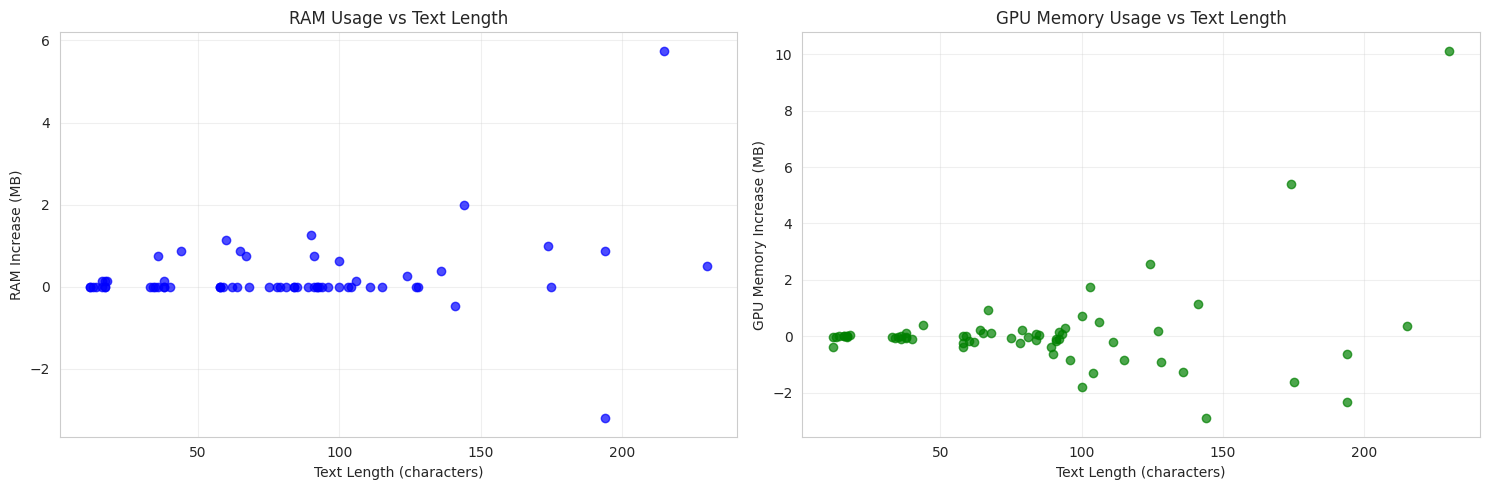

In [22]:
# Visualize memory usage
if len(memory_df) > 1:
    fig, axes = plt.subplots(1, 2 if torch.cuda.is_available() else 1, figsize=(15, 5))
    if not torch.cuda.is_available():
        axes = [axes]
    
    # RAM usage
    axes[0].scatter(memory_df['text_length'], memory_df['ram_increase_mb'], alpha=0.7, color='blue')
    axes[0].set_xlabel('Text Length (characters)')
    axes[0].set_ylabel('RAM Increase (MB)')
    axes[0].set_title('RAM Usage vs Text Length')
    axes[0].grid(True, alpha=0.3)
    
    # GPU usage (if available)
    if torch.cuda.is_available() and len(axes) > 1:
        axes[1].scatter(memory_df['text_length'], memory_df['gpu_increase_mb'], alpha=0.7, color='green')
        axes[1].set_xlabel('Text Length (characters)')
        axes[1].set_ylabel('GPU Memory Increase (MB)')
        axes[1].set_title('GPU Memory Usage vs Text Length')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 2.5 Comprehensive Analysis & Summary

This section consolidates all profiling results and provides:
- **Performance Summary**: Overall RTF and timing analysis
- **Bottleneck Identification**: Key performance bottlenecks in VITS
- **Memory Efficiency**: Memory usage patterns and recommendations
- **Optimization Opportunities**: Areas for potential improvements

In [23]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

def generate_analysis_report(rtf_results, memory_results, profiling_results):
    """
    Generate comprehensive analysis report from profiling data.
    
    Args:
        rtf_results: List of RTF measurement results
        memory_results: List of memory profiling results
        profiling_results: Dictionary containing profiler data
        
    Returns:
        Dictionary containing analysis summary and recommendations
    """
    report = {
        'performance_summary': {},
        'memory_analysis': {},
        'recommendations': []
    }
    
    # Performance Analysis
    rtf_values = [r.get('mean_rtf', 0) for r in rtf_results if r.get('mean_rtf')]
    if rtf_values:
        report['performance_summary'] = {
            'mean_rtf': np.mean(rtf_values),
            'min_rtf': np.min(rtf_values),
            'max_rtf': np.max(rtf_values),
            'std_rtf': np.std(rtf_values),
            'real_time_capable': all(rtf < 1.0 for rtf in rtf_values)
        }
    
    # Memory Analysis
    if memory_results:
        ram_increases = [r.get('ram_increase_mb', 0) for r in memory_results]
        gpu_increases = [r.get('gpu_increase_mb', 0) for r in memory_results 
                        if 'gpu_increase_mb' in r]
        
        report['memory_analysis'] = {
            'mean_ram_increase_mb': np.mean(ram_increases) if ram_increases else 0,
            'max_ram_increase_mb': np.max(ram_increases) if ram_increases else 0,
            'mean_gpu_increase_mb': np.mean(gpu_increases) if gpu_increases else 0,
            'max_gpu_increase_mb': np.max(gpu_increases) if gpu_increases else 0
        }
    
    # Generate Recommendations
    perf = report['performance_summary']
    mem = report['memory_analysis']
    
    if perf.get('mean_rtf', 1) > 1.0:
        report['recommendations'].append(
            "⚠️ RTF > 1.0: Model is slower than real-time, consider optimizations"
        )
    elif perf.get('mean_rtf', 1) < 0.5:
        report['recommendations'].append(
            "✅ RTF < 0.5: Excellent real-time performance"
        )
    else:
        report['recommendations'].append(
            "✅ RTF < 1.0: Good real-time performance"
        )
    
    if mem.get('max_gpu_increase_mb', 0) > 1000:
        report['recommendations'].append(
            "⚠️ High GPU memory usage (>1GB), consider batch size optimization"
        )
    elif mem.get('max_gpu_increase_mb', 0) > 500:
        report['recommendations'].append(
            "💡 Moderate GPU memory usage, monitor for longer sequences"
        )
    
    if mem.get('max_ram_increase_mb', 0) > 500:
        report['recommendations'].append(
            "⚠️ High RAM usage, consider memory-efficient inference"
        )
    
    return report


def create_profiler_summary(profiling_results, top_n=5):
    """
    Extract top operations from profiler results.
    
    Args:
        profiling_results: Dictionary containing profiler data
        top_n: Number of top operations to extract
        
    Returns:
        Dictionary with top CPU and GPU operations
    """
    summary = {'cpu_ops': [], 'gpu_ops': []}
    
    if 'profiler' not in profiling_results:
        return summary
    
    prof = profiling_results['profiler']
    key_averages = prof.key_averages()
    
    # Top CPU operations
    top_cpu_ops = sorted(key_averages, key=lambda x: x.cpu_time_total, reverse=True)[:top_n]
    summary['cpu_ops'] = [
        {'name': op.key, 'time_ms': op.cpu_time_total / 1000}
        for op in top_cpu_ops
    ]
    
    # Top GPU operations
    if torch.cuda.is_available():
        # Use self_cuda_time_total or device_time_total depending on PyTorch version
        top_gpu_ops = sorted(
            key_averages, 
            key=lambda x: getattr(x, 'self_cuda_time_total', getattr(x, 'device_time_total', 0)), 
            reverse=True
        )[:top_n]
        summary['gpu_ops'] = [
            {
                'name': op.key, 
                'time_ms': getattr(op, 'self_cuda_time_total', getattr(op, 'device_time_total', 0)) / 1000
            }
            for op in top_gpu_ops
        ]
    
    return summary


def display_analysis_report(report, profiler_summary):
    """
    Display comprehensive analysis report with formatted output.
    
    Args:
        report: Analysis report dictionary
        profiler_summary: Profiler operations summary
    """
    display(Markdown("# Comprehensive VITS Profiling Report"))
    
    # Performance Summary
    perf = report['performance_summary']
    display(Markdown("## Performance Summary"))
    
    perf_df = pd.DataFrame([{
        'Metric': 'Mean RTF',
        'Value': f"{perf.get('mean_rtf', 0):.3f}"
    }, {
        'Metric': 'RTF Range',
        'Value': f"{perf.get('min_rtf', 0):.3f} - {perf.get('max_rtf', 0):.3f}"
    }, {
        'Metric': 'Std Dev',
        'Value': f"{perf.get('std_rtf', 0):.3f}"
    }, {
        'Metric': 'Real-time Capable',
        'Value': '✅ Yes' if perf.get('real_time_capable', False) else '❌ No'
    }])
    display(perf_df)
    
    # Memory Analysis
    mem = report['memory_analysis']
    display(Markdown("## Memory Analysis"))
    
    mem_data = [{
        'Metric': 'Mean RAM Increase',
        'Value': f"{mem.get('mean_ram_increase_mb', 0):.1f} MB"
    }, {
        'Metric': 'Max RAM Increase',
        'Value': f"{mem.get('max_ram_increase_mb', 0):.1f} MB"
    }]
    
    if torch.cuda.is_available():
        mem_data.extend([{
            'Metric': 'Mean GPU Increase',
            'Value': f"{mem.get('mean_gpu_increase_mb', 0):.1f} MB"
        }, {
            'Metric': 'Max GPU Increase',
            'Value': f"{mem.get('max_gpu_increase_mb', 0):.1f} MB"
        }])
    
    mem_df = pd.DataFrame(mem_data)
    display(mem_df)
    
    # Profiler Insights
    if profiler_summary['cpu_ops']:
        display(Markdown("## Top Operations"))
        
        display(Markdown("#### CPU Operations"))
        cpu_df = pd.DataFrame(profiler_summary['cpu_ops'])
        cpu_df.columns = ['Operation', 'Time (ms)']
        cpu_df['Time (ms)'] = cpu_df['Time (ms)'].apply(lambda x: f"{x:.1f}")
        display(cpu_df)
        
        if profiler_summary['gpu_ops']:
            display(Markdown("#### GPU Operations"))
            gpu_df = pd.DataFrame(profiler_summary['gpu_ops'])
            gpu_df.columns = ['Operation', 'Time (ms)']
            gpu_df['Time (ms)'] = gpu_df['Time (ms)'].apply(lambda x: f"{x:.1f}")
            display(gpu_df)
    
    # Recommendations
    display(Markdown("## Recommendations"))
    for rec in report['recommendations']:
        display(Markdown(f"- {rec}"))


# Generate comprehensive report
analysis_report = generate_analysis_report(rtf_results, memory_results, profiling_results)
profiler_summary = create_profiler_summary(profiling_results)

# Display results
display_analysis_report(analysis_report, profiler_summary)

# Comprehensive VITS Profiling Report

## Performance Summary

,Metric,Value
0,Mean RTF,0.045
1,RTF Range,0.028 - 0.155
2,Std Dev,0.023
3,Real-time Capable,✅ Yes


## Memory Analysis

,Metric,Value
0,Mean RAM Increase,0.0 MB
1,Max RAM Increase,0.0 MB
2,Mean GPU Increase,0.0 MB
3,Max GPU Increase,0.0 MB


## Top Operations

#### CPU Operations

,Operation,Time (ms)
0,vits_inference,324.5
1,aten::copy_,204.7
2,aten::to,201.1
3,aten::_to_copy,201.0
4,cudaMemcpyAsync,192.5


#### GPU Operations

,Operation,Time (ms)
0,vits_inference,294.6
1,vits_inference,260.9
2,aten::convolution,193.5
3,aten::_convolution,193.5
4,aten::conv1d,180.0


## Recommendations

- ✅ RTF < 0.5: Excellent real-time performance